# Augmentation 1

In [2]:
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Define functions

In [4]:
def load_data(dir_path):
    x = []
    y = []
    for class_dir in dir_path.iterdir():
        print(f"Loading dataset {class_dir}")
        if class_dir.is_dir():
    
            for img_file in class_dir.iterdir():
                if img_file.is_file():
                    img = cv2.imread(img_file)
                    img = cv2.resize(img, (32, 32))
                    img = np.array(img)
                    img = img / 255.0
                    x.append(img)
                    y.append(class_dir.name)
    return x, y

def plot_history(history, title, figsize=(14, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], linewidth=2)
    plt.plot(history.history['val_accuracy'], linewidth=2)

    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_val_acc_epoch]
    plt.plot(best_val_acc_epoch, best_val_acc, 'ro', markersize=8)
    plt.annotate(f'{best_val_acc:.4f}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(best_val_acc_epoch + 0.5, best_val_acc - 0.05),
                 fontsize=10)

    plt.title(f'{title} - Genauigkeit (Accuracy)', fontsize=12, fontweight='bold')
    plt.ylabel('Genauigkeit', fontsize=11)
    plt.xlabel('Epoche', fontsize=11)
    plt.ylim([0, 1.05])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Training', 'Validierung', 'Bestes Modell'], loc='lower right', frameon=True, fancybox=True, shadow=True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], linewidth=2)
    plt.plot(history.history['val_loss'], linewidth=2)

    best_val_loss_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.plot(best_val_loss_epoch, best_val_loss, 'ro', markersize=8)
    plt.annotate(f'{best_val_loss:.4f}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(best_val_loss_epoch + 0.5, best_val_loss + 0.1),
                 fontsize=10)

    plt.title(f'{title} - Verlustfunktion (Loss)', fontsize=12, fontweight='bold')
    plt.ylabel('Verlust', fontsize=11)
    plt.xlabel('Epoche', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Training', 'Validierung', 'Bestes Modell'], loc='upper right', frameon=True, fancybox=True, shadow=True)

    if 'lr' in history.history:
        plt.figure(figsize=(7, 3))
        plt.plot(history.history['lr'], linewidth=2)
        plt.title('Learning Rate Verlauf', fontsize=12, fontweight='bold')
        plt.ylabel('Learning Rate', fontsize=11)
        plt.xlabel('Epoche', fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.yscale('log')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test_cat):
    try:
        print("Modell-Metriken:", model.metrics_names)
        evaluation_results = model.evaluate(X_test, y_test_cat, verbose=1)

        results_dict = {}
        for i, metric_name in enumerate(model.metrics_names):
            results_dict[metric_name] = evaluation_results[i]
            print(f"{metric_name}: {evaluation_results[i]:.4f}")

        return results_dict

    except Exception as e:
        print(f"Fehler bei der Modellauswertung: {e}")
        loss = model.evaluate(X_test, y_test_cat, verbose=0)
        print(f"Loss: {loss:.4f}")
        return {'loss': loss}

def plot_confusion_matrix(y_true, y_pred, title="Konfusionsmatrix", figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred)
    print("CM in der Funktion:", cm)

    if cm.shape != (2, 2):
        print(f"WARNUNG: Konfusionsmatrix hat unerwartete Dimensionen: {cm.shape}")
        if cm.shape[0] > 2 or cm.shape[1] > 2:
            cm_new = np.zeros((2, 2))
            cm_new[0, 0] = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
            cm_new[0, 1] = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
            cm_new[1, 0] = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
            cm_new[1, 1] = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
            cm = cm_new
            print("Korrigierte Matrix:", cm)

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100

    annot = np.zeros_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n{cm_perc[i, j]:.1f}%"

    plt.figure(figsize=figsize)

    ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                    linewidths=1, linecolor='black', annot_kws={"size": 12})

    plt.title(f'{title}\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Wahre Klasse', fontsize=12, fontweight='bold')
    plt.xlabel('Vorhergesagte Klasse', fontsize=12, fontweight='bold')

    ax.xaxis.set_ticklabels(['Kein Waldbrand', 'Waldbrand'], fontsize=10)
    ax.yaxis.set_ticklabels(['Kein Waldbrand', 'Waldbrand'], fontsize=10)

    plt.tight_layout()
    plt.show()

    print("\nKlassifikationsmetriken:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

def vorhersage_einzelbild(model, bild_pfad, img_width=64, img_height=64, threshold=0.5):
    try:
        bild = cv2.imread(bild_pfad)
        if bild is None:
            print(f"Fehler: Bild konnte nicht geladen werden - {bild_pfad}")
            return None, None

        bild_anzeige = cv2.cvtColor(bild, cv2.COLOR_BGR2RGB)
        bild = cv2.resize(bild, (img_width, img_height))
        bild = bild / 255.0
        bild = np.expand_dims(bild, axis=0)

        vorhersage = model.predict(bild, verbose=0)
        klasse_wahrscheinlichkeit = vorhersage[0][1]

        klasse_name = 'Waldbrand' if klasse_wahrscheinlichkeit > threshold else 'Kein Waldbrand'

        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(bild_anzeige)
        plt.title(f'Vorhersage: {klasse_name}', fontsize=12, fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        waldbrand_conf = vorhersage[0][1] * 100
        kein_waldbrand_conf = vorhersage[0][0] * 100

        bars = plt.barh(['Waldbrand', 'Kein Waldbrand'],
                        [waldbrand_conf, kein_waldbrand_conf],
                        color=['crimson', 'forestgreen'])

        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center', fontweight='bold')

        plt.xlim([0, 105])
        plt.title('Konfidenz (%)', fontsize=12, fontweight='bold')
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        plt.gca().set_facecolor('#ffeeee' if klasse_name == 'Waldbrand' else '#eeffee')

        plt.axvline(x=threshold*100, color='blue', linestyle='--', linewidth=2)
        plt.text(threshold*100 + 1, 0.5, f'Schwellenwert ({threshold*100:.0f}%)',
                 ha='left', va='center', color='blue', fontweight='bold')

        plt.tight_layout()
        plt.show()

        return klasse_name, klasse_wahrscheinlichkeit

    except Exception as e:
        print(f"Fehler bei der Bildvorhersage: {e}")
        return None, None

#### Load data

In [6]:
x_train, y_train = load_data(Path(r"dataset/train"))
x_valid, y_valid = load_data(Path("dataset/valid"))
x_test, y_test = load_data(Path("dataset/test"))

Loading dataset dataset\train\nowildfire
Loading dataset dataset\train\wildfire
Loading dataset dataset\valid\nowildfire
Loading dataset dataset\valid\wildfire
Loading dataset dataset\test\nowildfire
Loading dataset dataset\test\wildfire


In [7]:
print("Number of images in train:", len(x_train))
print("Shape of first image in train:", x_train[0].shape)
print("First label in train:", y_train[0])

Number of images in train: 30250
Shape of first image in train: (32, 32, 3)
First label in train: nowildfire


i = 8605


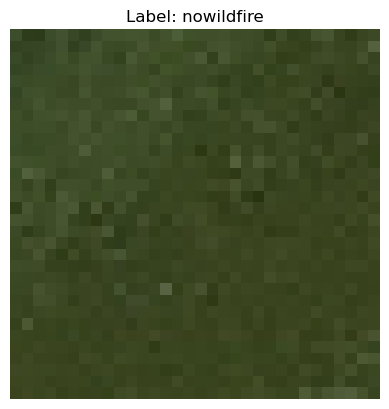

i = 23618


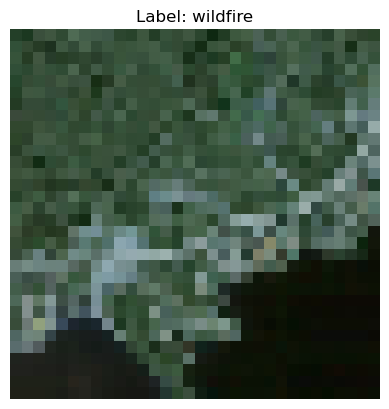

i = 15821


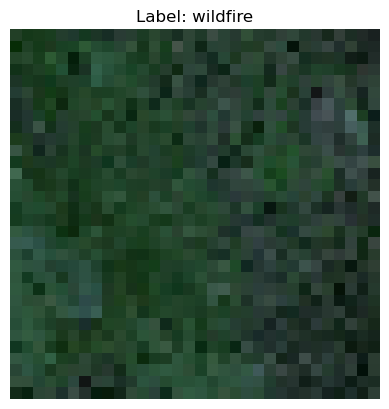

i = 23752


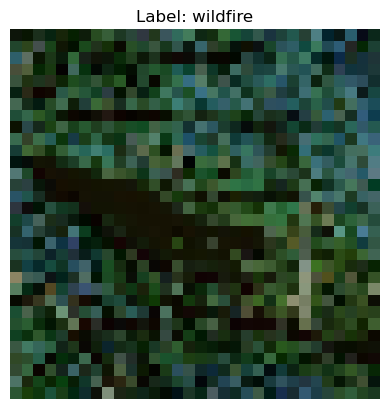

i = 25691


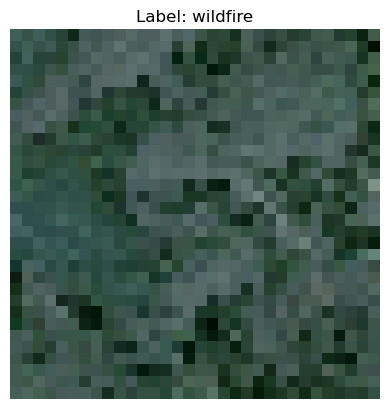

In [8]:
for i in random.sample(range(len(x_train)),5):
    print(f"i = {i}")
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
    plt.show()

In [9]:
print("Number of images in valid:", len(x_valid))
print("Shape of first image in valid:", x_valid[0].shape)
print("First label in valid:", y_valid[0])

Number of images in valid: 6300
Shape of first image in valid: (32, 32, 3)
First label in valid: nowildfire


In [10]:
print("Number of images in test:", len(x_test))
print("Shape of first image in test:", x_test[0].shape)
print("First label in test:", y_test[0])

Number of images in test: 6300
Shape of first image in test: (32, 32, 3)
First label in test: nowildfire


#### Encode labels

Machine learning models can't understand "wildfire" or "nowildfire" directly — they need numerical representations. We use the label_map here to turn strings into class indices (e.g., ["wildfire", "nowildfire"] → [0, 1])

In [12]:
label_map = {'nowildfire':0, 'wildfire':1}
y_train_encoded = [label_map[label] for label in y_train]
y_valid_encoded = [label_map[label] for label in y_valid]
y_test_encoded = [label_map[label] for label in y_test]
# print(y_train_encoded)
# print(y_valid_encoded)

#### Convert lists to numpy arrays

In [14]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

y_train_encoded = np.array(y_train_encoded)
y_valid_encoded = np.array(y_valid_encoded)
y_test_encoded = np.array(y_test_encoded)

#### Create neural network

In [89]:
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.summary()
    return model

#### Data Augmentation

In [102]:
train_datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    vertical_flip=False
)

batch_size = 32

train_generator = train_datagen.flow(
    x_train, y_train_encoded,
    batch_size=batch_size,
    shuffle=True
)

#### Compile and train neural network

In [105]:
model = create_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
history = model.fit(
    train_generator,
    validation_data = (x_valid, y_valid_encoded),
    batch_size = batch_size,
    epochs = 10
    )

Epoch 1/10


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8573 - loss: 0.3115 - val_accuracy: 0.8841 - val_loss: 0.2720
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9226 - loss: 0.1996 - val_accuracy: 0.9189 - val_loss: 0.2078
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9322 - loss: 0.1773 - val_accuracy: 0.9278 - val_loss: 0.1944
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9386 - loss: 0.1647 - val_accuracy: 0.9146 - val_loss: 0.2380
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9385 - loss: 0.1629 - val_accuracy: 0.9214 - val_loss: 0.2428
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9447 - loss: 0.1482 - val_accuracy: 0.9406 - val_loss: 0.1709
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9451 - loss: 0.1461 - val_accuracy: 0.9503 - val_loss: 0.1404
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9490 - loss: 0.1398 - val_accurac

#### Plot results

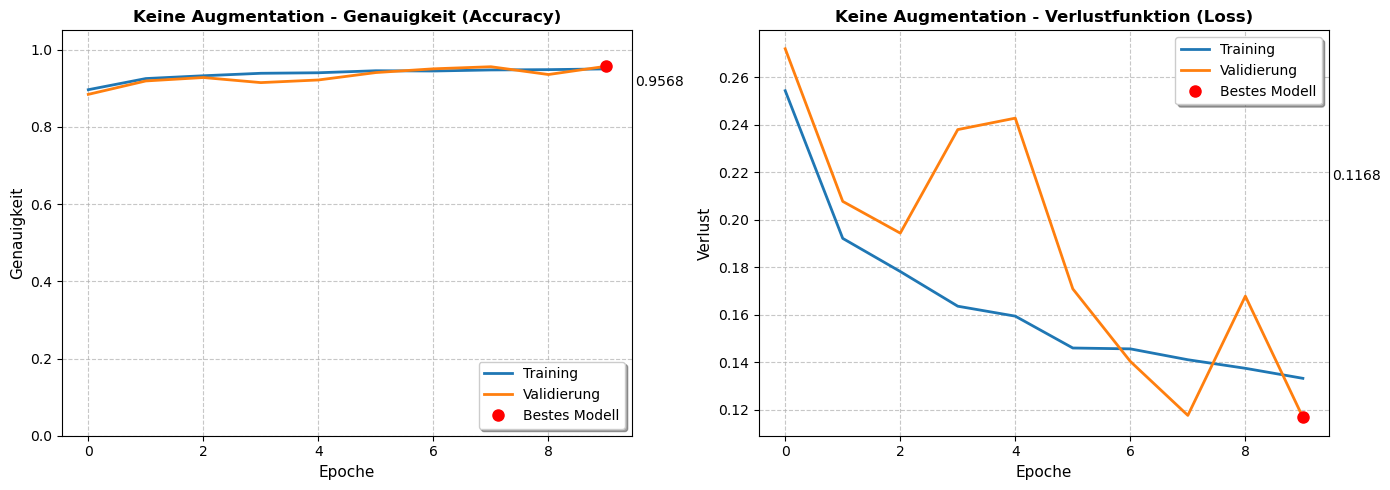

Modell-Metriken: ['loss', 'compile_metrics']
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.0956
loss: 0.0987
compile_metrics: 0.9617
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CM in der Funktion: [[2696  124]
 [ 117 3363]]


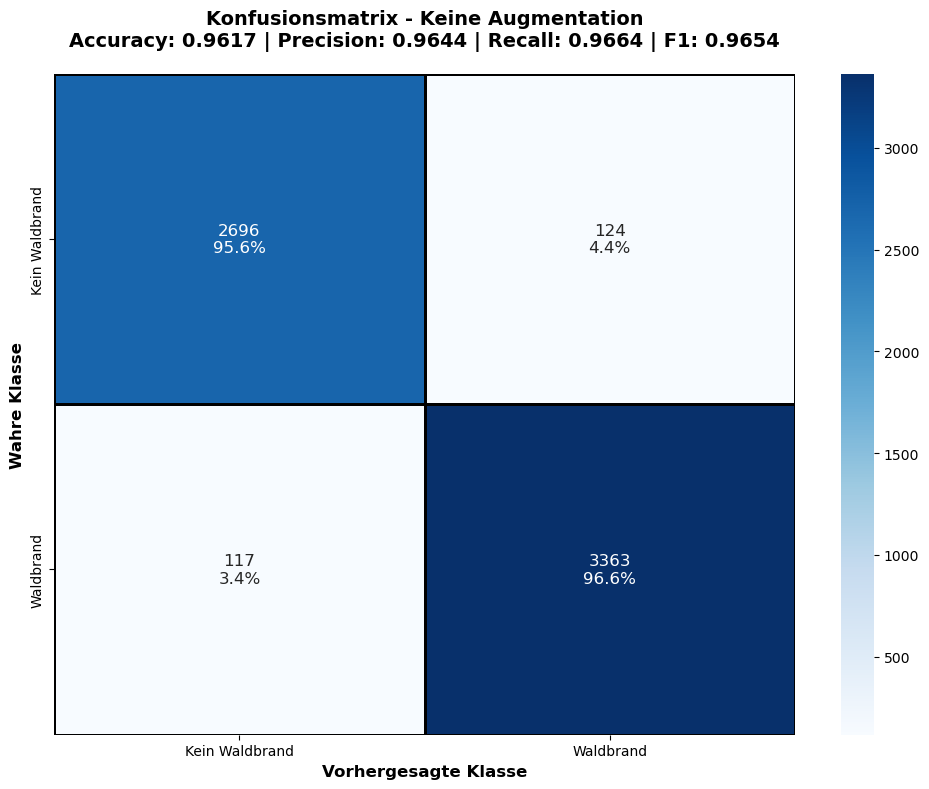


Klassifikationsmetriken:
Accuracy: 0.9617
Precision: 0.9644
Recall: 0.9664
F1-Score: 0.9654


In [109]:
plot_history(history, 'Keine Augmentation')

eval_results = evaluate_model(model, x_test, y_test_encoded)

predictions = model.predict(x_test)
# y_pred = np.argmax(predictions, axis=1)
y_pred = (predictions.flatten() > 0.5).astype(int)
y_true = y_test_encoded
plot_confusion_matrix(y_true, y_pred, title="Konfusionsmatrix - Keine Augmentation")